In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [33]:
# Загрузка датасета
! kaggle competitions download -c histopathologic-cancer-detection

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
i! unzip histopathologic-cancer-detection.zip

In [18]:
labels_df = pd.read_csv('/content/train_labels.csv')
print(labels_df.head().to_markdown())

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |


In [21]:
labels_df.shape

(220025, 2)

In [23]:
# Проверяем на наличие дубликатов строк в таблице данных. Вывод будет пустым, если дубликатов нет.
labels_df[labels_df.duplicated(keep=False)]

Empty DataFrame
Columns: [id, label]
Index: []

In [25]:
#Считаем количество экземпляров каждого класса меток
label_counts = labels_df['label'].value_counts()
label_counts

label
0    130908
1     89117
Name: count, dtype: int64

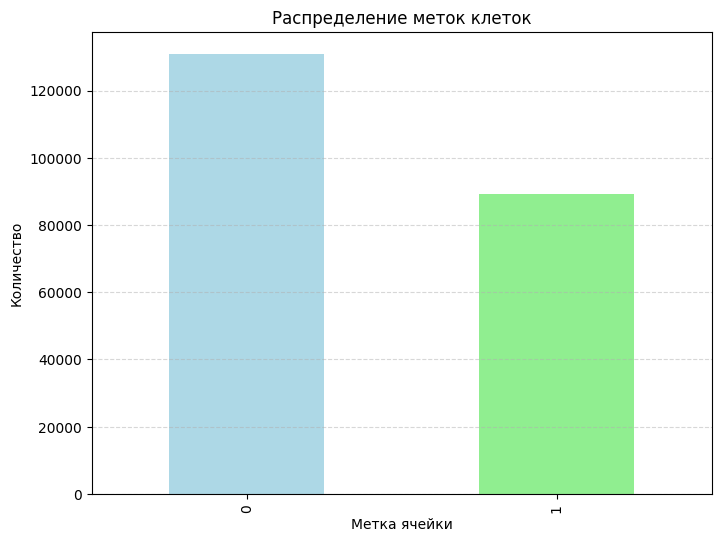

In [35]:
# Создаем гистограмму для визуализации распределения меток по классам. Используем разные цвета для меток.
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['lightblue', 'lightgreen'])
plt.title('Распределение меток клеток')
plt.xlabel('Метка ячейки')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [38]:
# Путь к изображениям
imgpath ="/content/train"
malignant = labels_df.loc[labels_df['label']==1]['id'].values
normal = labels_df.loc[labels_df['label']==0]['id'].values

print('ID нормальных изображений:')
print(normal[0:3],'\n')

print('ID злокачественных изображений:')
print(malignant[0:3])

ID нормальных изображений:
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'] 

ID злокачественных изображений:
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


In [41]:
# Функция для визуализации изображений
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

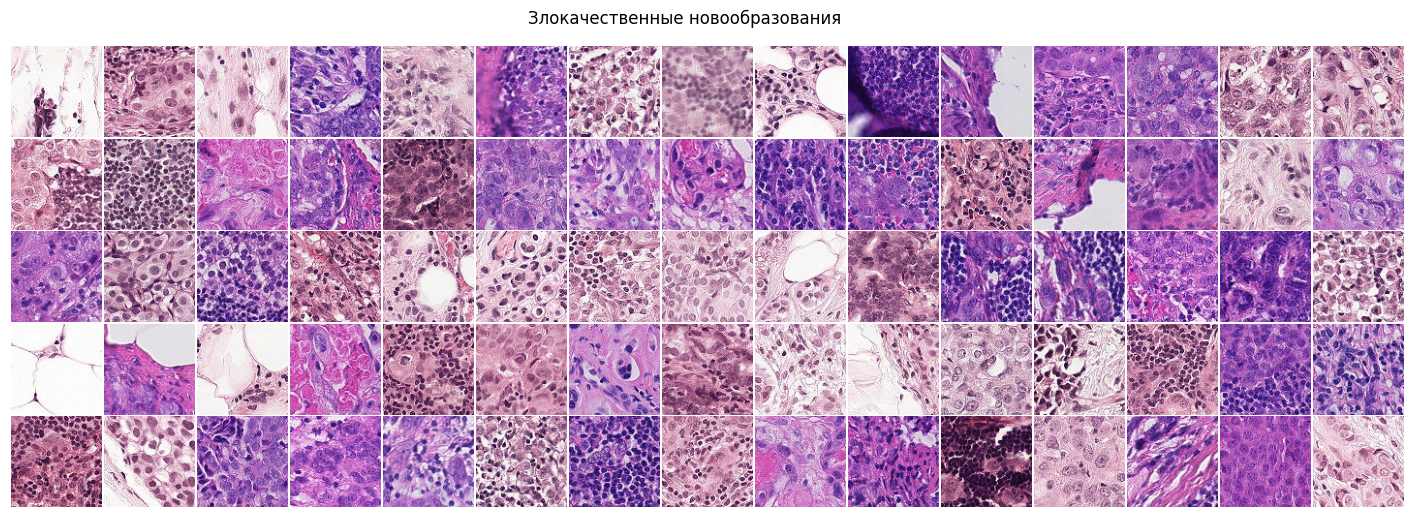

In [43]:
plot_fig(malignant,'Злокачественные новообразования')

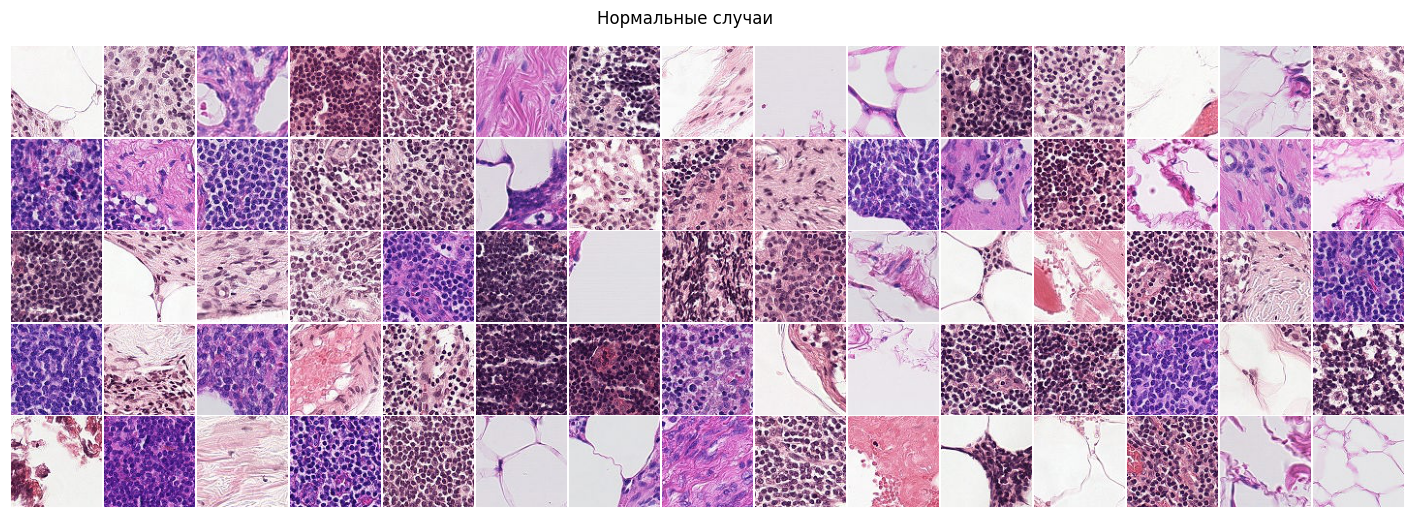

In [47]:
plot_fig(normal,'Нормальные случаи')

In [45]:
len(labels_df)

220025

In [49]:
torch.manual_seed(0)

# Обработка и подготовка данных для модели
class pytorch_data(Dataset):

    def __init__(self, data_dir, transform, data_type = 'train'):

        #Формирование списка файлов с данными
        cdm_data = os.path.join(data_dir, data_type)

        file_names = os.listdir(cdm_data)
        idx_choose = np.random.choice(np.arange(len(file_names)),4000, replace = False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]

        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]

        labels_data = os.path.join(data_dir, "/content/train_labels.csv")
        labels_df = pd.read_csv(labels_data)
        labels_df.set_index("id", inplace = True)
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]
        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)

    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]


In [50]:
# Определение преобразований, которые преобразуют изображения PIL в тензоры PyTorch
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

In [56]:
# Определение объекта пользовательского набора данных для папки train.
data_dir = '/content'
img_dataset = pytorch_data(data_dir, data_transformer, "train") # Гистопатологические изображения

In [57]:
# Загрузка примера тензора
img,label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 46, 46]) tensor(0.0939) tensor(0.9762)


In [63]:
len_img = len(img_dataset)
len_train = int(0.7*len_img)
len_val = len_img - len_train

# разделенный тензор pytorch
train_ts, val_ts = random_split(img_dataset, [len_train, len_val]) # случайное распределение 70/30

print("Размер обучающего набора данных:", len(train_ts))
print("Размер набора данных для проверки:", len(val_ts))

Размер обучающего набора данных: 2800
Размер набора данных для проверки: 1200


In [64]:
# Перебираем первые несколько изображений из обучающего набора.
ii =-1
for x,y in train_ts:
    print(x.shape, y)
    ii += 1
    if (ii>5):
        break

torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0


In [65]:
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

In [69]:
# Создание сетки из изображений (обучающий набор)
grid_size=30
rnd_inds=np.random.randint(0, len(train_ts),grid_size)
print("Индексы изображений:", rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)

plot_img(x_grid_train,y_grid_train,'Примеры обучающего набора')

Индексы изображений: [1349 2613  737 2601  977 2116 2083 1307  191  946 2030 1691 1295 1885
 1772   81 1197 1751  156   66  252  202 1173  121 1736   59 2710  145
 2146   44]
torch.Size([3, 146, 482])


In [71]:
# Создание сетки из изображений (валидационный набор)
grid_size=30
rnd_inds=np.random.randint(0,len(val_ts),grid_size)
print("Индексы изображений:", rnd_inds)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=10, padding=2)
print(x_grid_val.shape)

plot_img(x_grid_val,y_grid_val,'Примеры валидационного набора')

Индексы изображений: [ 882   24  892  159  349  580  646  693   37  779  630   74  497  142
  831  599 1135  300 1188   32  791  172  966  264  897  434  883 1019
 1003  871]
torch.Size([3, 146, 482])


# Определения аугментации изображений

**АУГМЕНТАЦИЯ ИЗОБРАЖЕНИЙ**

*   Наряду с предварительно обученными моделями, преобразования и аугментация изображений обычно считаются важными составляющими при создании моделей глубокого обучения.
*   Используя преобразования изображений, мы можем расширить набор данных, а также изменить размер или нормализовать изображения для достижения лучшей производительности модели.
*   Типичные преобразования включают горизонтальное и вертикальное отражение, поворот, изменение размера.

**Для чего используем аугментации?**

*   Мы можем применять различные преобразования для нашей модели бинарной классификации (например, "злокачественно/нормально") без изменения метки.
*   Например, перевернутая или повернутая злокачественная клетка всё равно останется злокачественной.

**Инструменты для аугментации**

*   Мы можем использовать модуль torchvision для выполнения преобразований изображений в процессе обучения.

---

**АУГМЕНТАЦИИ ДАННЫХ ДЛЯ ОБУЧЕНИЯ**

*   transforms.RandomHorizontalFlip(p=0.5): С вероятностью 50% отражает изображение по горизонтали.

*   transforms.RandomVerticalFlip(p=0.5): С вероятностью 50% отражает изображение по вертикали.

*   transforms.RandomRotation(45): Поворачивает изображения в диапазоне от -45 до +45 градусов.

*   transforms.RandomResizedCrop(96, scale=(0.8, 1.0), ratio=(1.0, 1.0)): Случайным образом обрезает изображение до квадратной области в диапазоне от 72x72 до 96x96, после чего изменяет размер до 96x96 (исходный размер изображения).

*   transforms.ToTensor(): Преобразует изображение в тензор PyTorch и нормализует его значения (как обсуждалось ранее).

In [72]:
# Определение следующие преобразования для обучающего набора данных
tr_transf = transforms.Compose([
#     transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
#     transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

In [73]:
# Для проверки набора данных нам не нужно никаких дополнений; просто преобразовывем изображения в тензоры
val_transf = transforms.Compose([
    transforms.ToTensor()])

# После определения преобразований перезаписываем функции преобразований train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

In [75]:
# Проверка установленного преобразования
train_ts.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

# Создание Dataloaders

*   Подготовка к созданию PyTorch Dataloader. Если не использовать PyTorch Dataloader, то придется писать код для автоматического перебора наборов данных и извлечения пакета данных.
*   Нужно определить batch_size: количество изображений, извлекаемых из набора данных на каждой итерации.

In [76]:
from torch.utils.data import DataLoader

# Загрузчик обучающих данных
train_dl = DataLoader(train_ts,
                      batch_size=32,
                      shuffle=True)

# Загрузчик проверочных данных
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    shuffle=False)

In [77]:
# Проверка выборки из обучающего Dataloader
for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([32, 3, 46, 46]) tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 0])
